In [1]:
 ## 2D Simulation

%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ["GRB_LICENSE_FILE"] = "/gpfs1/sw/rh9/pkgs/gurobi/13.0.0/linux64/licenses/gurobi.lic"

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Load Model
base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [3]:
# Set default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

#COMETS models
bif = c.model(base1)
eub = c.model(base2)

bif.open_exchanges()
eub.open_exchanges()

#bifido_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"
#Eubacterium_comets.obj_style = "MAX_OBJECTIVE_MIN_TOTAL"

# Clean non-EX exchanges (Comets fixed issue)
for m in [bif, eub]:
    ex_mask = m.reactions["EXCH"].isin([True, "True"])
    exchanges_df = m.reactions[ex_mask]
    for name in exchanges_df["REACTION_NAMES"]:
        name = str(name)
        if not name.startswith("EX_"):
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH"] = False
            m.reactions.loc[m.reactions["REACTION_NAMES"] == name, "EXCH_IND"] = 0

In [4]:
# metabolite to exchange reaction mappings
met_to_ex1 = {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex1[met.id] = rxn.id

met_to_ex2 = {}
for rxn in base2.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex2[met.id] = rxn.id

# all external metabolites
all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())

In [5]:
#  COMETS issue workaround: (FIXED)
#Function to add missing closed exchanges
def add_missing_closed_exchanges(model, met_to_ex_self_real, all_ext_mets, label):
    '''
    For each external metabolite in all_ext_mets that this model doesn't have
    a REAL exchange for, add a CLOSED dummy exchange reaction:
        EX_added_<met_id>: met[e] -> with LB = 0, UB = 0.
    '''
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}

    for met_id in all_ext_mets:
        if met_id in met_to_ex_self_real:
            continue  # this model already has a real exchange for this metabolite

        # Ensure external metabolite exists in the model
        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
            #print(f"[{label}] Added external metabolite {met_id}")

        # Create a closed dummy exchange reaction if it doesn't exist
        rxn_id = f"EX_added_{met_id}"
        if rxn_id in rxn_ids:
            continue

        rxn = cb.Reaction(rxn_id)
        rxn.name = f"Dummy exchange for {met_id} (closed)"
        rxn.lower_bound = 0.0  # CLOSED by default
        rxn.upper_bound = 0.0  # no secretion either
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)

        #print(f"[{label}] Added CLOSED dummy exchange {rxn_id} for {met_id}")

# Add missing exchanges to each model so both see the same set of external metabolites
add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, "Bifido")
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, "Eubacterium")


In [6]:
GRID_X = 30
GRID_Y = 20 # y=0 -top, y=GRID_Y-1 -bottom

x_bif = 5
gap = 17
x_eub = x_bif + gap + 1
y_top = 0

bif.initial_pop = [[x_bif, y_top, 0.01]]
eub.initial_pop = [[x_eub, y_top, 0.01]]

layout = c.layout([bif, eub])
layout.grid = [GRID_X, GRID_Y]


for met in all_ext_mets:
    layout.set_specific_metabolite(met, 0.0)
    layout.set_specific_refresh(met, 0.0)


trace_metabolites = [
    "h2o[e]", "pi[e]", "fe2[e]", "fe3[e]", "zn2[e]", "so4[e]", "cu2[e]", "k[e]", "mg2[e]",
    "mn2[e]", "cd2[e]", "cl[e]", "ca2[e]", "cobalt2[e]", "ribflv[e]",
    "pnto_R[e]", "nac[e]", "his_L[e]", "asn_L[e]", "glycys[e]", "lys_L[e]",
    "ala_L[e]", "met_L[e]", "leu_L[e]", "hxan[e]", "glyglu[e]"
]

for met in trace_metabolites:
    if met in all_ext_mets:
        layout.set_specific_metabolite(met, 100.0, static= True)
        #layout.set_specific_static(met, 1000.0)


# layout.set_specific_metabolite("glc_D[e]", 0.0)
# layout.set_specific_refresh("glc_D[e]", 0.0)

# glucose
glc_top = 2
for x in range(GRID_X):
    layout.set_specific_metabolite_at_location("glc_D[e]", (x, y_top), glc_top)
    #layout.set_specific_refresh_at_location("glc_D[e]", (x, y_top), 1)

# bottom row
y_bot = GRID_Y - 1
for x in range(GRID_X):
    layout.set_specific_metabolite_at_location("glc_D[e]", (x, y_bot), 0.0)
    layout.set_specific_refresh_at_location("glc_D[e]", (x, y_bot), 0.0)

# diffusion
layout.set_specific_metabolite_diffusion("glc_D[e]", 5e-8)


# Biomass motion parameters
for m in [bif, eub]:
    m.add_nonlinear_diffusion_parameters(5e-7, 5e-6, 1.0, 2.0, 1e-3)
    #m.add_nonlinear_diffusion_parameters(1e-6, 1e-5, 1.0, 2.0, 5e-4)

# D0 — baseline diffusion when biomass is very low.
# Dn — diffusion when biomass is high.
# n — exponent controlling the rate of increase of diffusion with biomass.
# N — Hill coefficient.
# K — half-saturation constant for the Hill equation. biomass level where diffusion is half‑max


#width = 0.01/GRID_Y
#vol = width**3

params = c.params()
params.set_param("maxCycles", 100)
params.set_param("timeStep", 0.01)   #0.01
params.set_param("spaceWidth", 0.01)
params.set_param("exchangestyle", "Monod Style")
params.set_param("writeMediaLog", True)
params.set_param("MediaLogRate", 10)
params.set_param("writeBiomassLog", True)
params.set_param("BiomassLogRate", 10)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 10)
params.set_param("biomassMotionStyle", "ConvNonlin Diffusion 2D")
params.set_param("defaultDiffConst", 6e-6)
params.set_param("maxSpaceBiomass", 0.9)
params.set_param("minSpaceBiomass", 1.0e-11)
params.set_param("allowCellOverlap", True)
params.set_param("growthDiffRate", 0.0)
params.set_param("defaultVmax", 10.0)
params.set_param("defaultKm", 0.001)
params.set_param("defaultHill", 1)


sim = c.comets(layout, params)
sim.run()


Running COMETS simulation ...
Done!


In [7]:
print(sim.run_output)

-script
running script file: /gpfs1/home/f/s/fsenya/vacc_comets_env/Projects/Project 4_new/.current_script_0x14f2715d6820
Current Java version: 21.0.9
Parameters file .current_global_0x14f2715d6820 loaded.
MAX CYCLES = -1
Parameters file .current_package_0x14f2715d6820 loaded.
MAX CYCLES = 100
Loading layout file '.current_layout_0x14f2715d6820'...
null/COMETS_manifest.txt (No such file or directory)
Unable to initialize manifest file. 
Continuing without writing manifest file.
Found 2 model files!
Loading './Bifido.cmd' ...
optim= 0
Set parameter TokenServer to value "gurobilm.uvm.edu"
Set parameter TokenServer to value "gurobilm.uvm.edu"
Done!
 Testing default parameters...
Done!
Optimizer status code = 5 (looks ok!)
here60.820248283046844
objective solution = 60.820248283046844
Loading './Eubacterium.cmd' ...
optim= 0
Set parameter TokenServer to value "gurobilm.uvm.edu"
Set parameter TokenServer to value "gurobilm.uvm.edu"
Done!
 Testing default parameters...
Done!
Optimizer status

In [8]:
sim.total_biomass

,cycle,Bifido,Eubacterium
0,0,0.010000,0.010000
1,1,0.010000,0.010000
2,2,0.010013,0.010040
3,3,0.010027,0.010081
4,4,0.010040,0.010121
...,...,...,...
96,96,0.011342,0.015023
97,97,0.011357,0.015091
98,98,0.011372,0.015158
99,99,0.011387,0.015227


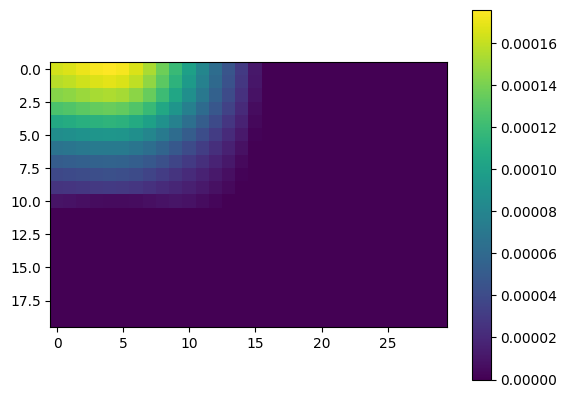

In [9]:
def biomass_image(sim, species, cycle):
    
    df = sim.biomass
    sub = df[(df["cycle"] == cycle) & (df["species"] == species)]
   
    im = np.zeros((GRID_X, GRID_Y))
    for _, row in sub.iterrows():
        im[int(row["x"]), int(row["y"])] = row["biomass"]
    return im

im = biomass_image(sim, "Bifido", 100)
plt.imshow(im.T, origin="upper")  
plt.colorbar()
plt.show()

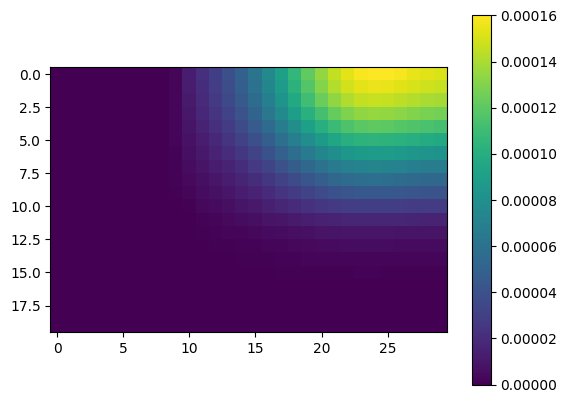

In [10]:
im = biomass_image(sim, "Eubacterium", 100)
plt.imshow(im.T, origin="upper") 
plt.colorbar()
plt.show()

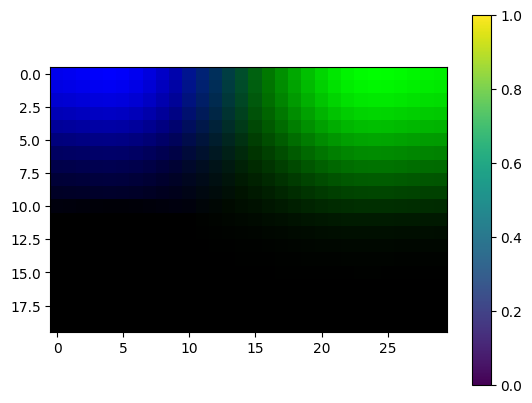

In [11]:
im_e = biomass_image(sim, "Eubacterium", 100)
im_b = biomass_image(sim, "Bifido", 100)

if im_e.max() > 0:
    im_e = im_e / im_e.max()
if im_b.max() > 0:
    im_b = im_b / im_b.max()

final = np.zeros((GRID_Y, GRID_X, 3))
final[:, :, 1] = im_e.T
final[:, :, 2] = im_b.T

plt.imshow(final, origin="upper")
plt.colorbar()
plt.show()

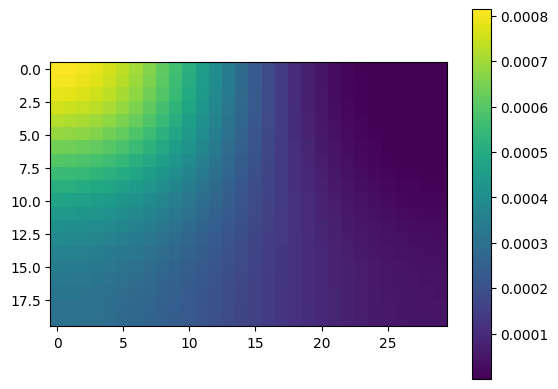

In [12]:
met="lac_L[e]"
im = sim.get_metabolite_image(met, 100)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()

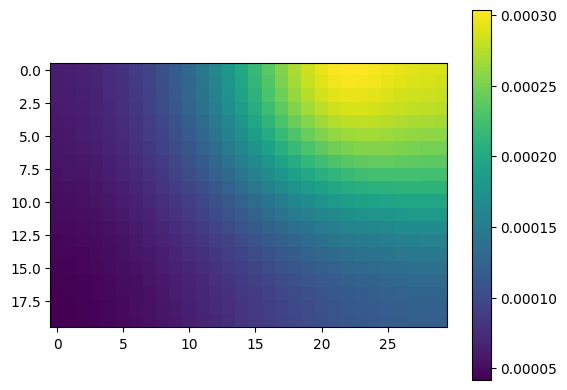

In [13]:
met="but[e]"
im = sim.get_metabolite_image(met, 100)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()

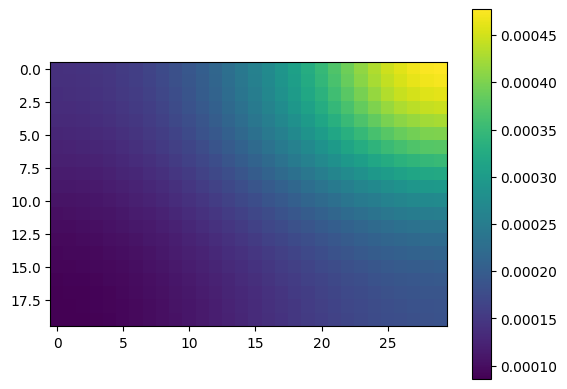

In [14]:
met="ac[e]"
im = sim.get_metabolite_image(met, 100)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()

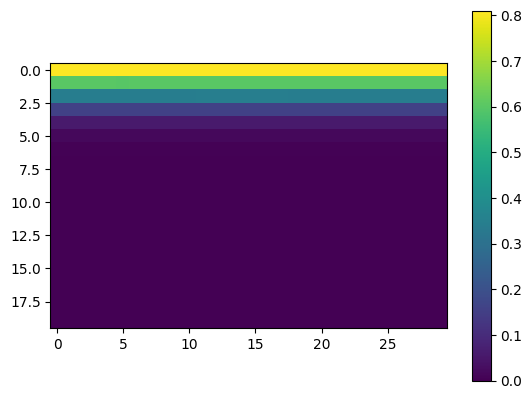

In [15]:
met="glc_D[e]"
im = sim.get_metabolite_image(met, 100)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()


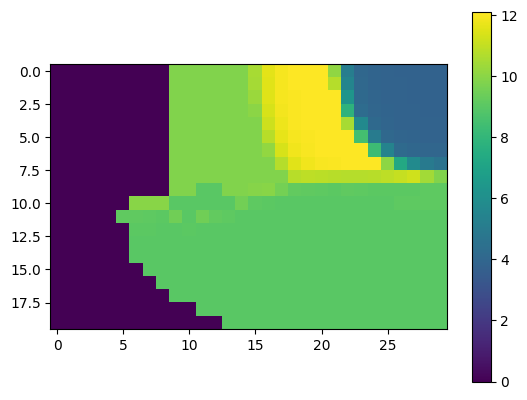

In [16]:
im = sim.get_flux_image("Eubacterium", "EX_but(e)", 70).astype(float)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()

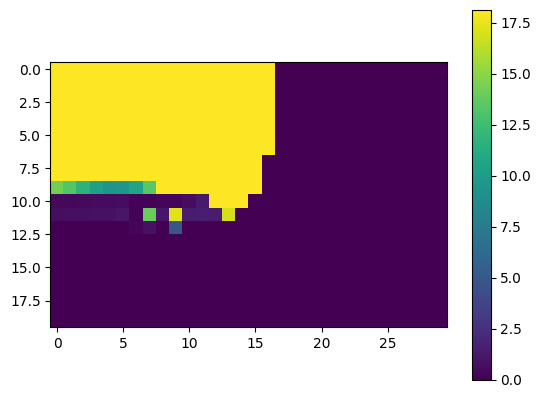

In [17]:
im = sim.get_flux_image("Bifido", "EX_lac_L(e)", 100).astype(float)

plt.imshow(im.T, origin="upper")
plt.colorbar()
plt.show()